In [1]:
from load_oxford_flowers102 import load_oxford_flowers102
import show_methods
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import gzip
import pickle
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from sklearn.metrics import classification_report, confusion_matrix

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
train_data, validation_data, test_data, class_names = load_oxford_flowers102(imsize=96, fine=True)
y_train = train_data["labels"]
y_test = test_data["labels"]
x_train = train_data["images"]
x_test = test_data["images"]
x_valid = validation_data["images"]
y_valid = validation_data["labels"]
input_shape = (96, 96, 3)
n_classes = len(class_names)

2024-04-15 19:29:06.050000: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 19:29:06.074750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 19:29:06.515375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqd

In [10]:

def eval_net(net, epochs=50, load_from_file=False, net_name="net", summary=False, verbose=1, show_train_graph=False, data_aug=False,show_predictions=False, callbacks=[], batch_size=32):
    save_name = os.path.join('saved', f'{net_name}')
    net_save_name = save_name + '_cnn_net.h5'
    checkpoint_save_name = save_name + '_cnn_net.chk.weights.h5'
    history_save_name = save_name + '_cnn_net.hist'


    if load_from_file and os.path.isfile(net_save_name):
      net = tf.keras.models.load_model(net_save_name)
      with gzip.open(history_save_name) as f:
         history = pickle.load(f)
    else:           
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_save_name,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
        callbacks = callbacks.append(model_checkpoint_callback)
        if data_aug:
            datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                zca_epsilon=1e-06,
                width_shift_range=0.1,
                height_shift_range=0.1,
                fill_mode='nearest',
                horizontal_flip=True
            )
            datagen.fit(x_train)

            train_data_aug = datagen.flow(x_train, y_train)

            train_info = net.fit(train_data_aug,
                                 validation_data=(x_valid, y_valid),
                                 epochs=epochs, shuffle=True,
                                 callbacks=callbacks,
                                 batch_size=batch_size,
                                 verbose=verbose)
        else:
            train_info = net.fit(x_train, y_train, 
                                 validation_data=(x_valid, y_valid),
                                 epochs=epochs, shuffle=True,
                                 callbacks=callbacks,
                                 batch_size=batch_size,
                                 verbose=verbose)
        net.save(net_save_name)
        history = train_info.history
        with gzip.open(history_save_name, 'w') as f:
            pickle.dump(history, f)

    if summary:
        net.summary()

    # Compute output for 16 test images
    y_test_pred = net.predict(x_test)
    y_train_pred = net.predict(x_train)

    loss_train, accuracy_train,  = net.evaluate(x_train, y_train, verbose=0)
    loss_test, accuracy_test = net.evaluate(x_test, y_test, verbose=0)

    print("Train accuracy (tf): %.2f" % accuracy_train)
    print("Test accuracy  (tf): %.2f" % accuracy_test)

    if show_train_graph:
        #Plot training and validation accuracy over the course of training
        fh = plt.figure()
        ph = fh.add_subplot(111)
        ph.plot(history['accuracy'], label='accuracy')
        ph.plot(history['val_accuracy'], label = 'val_accuracy')
        ph.set_xlabel('Epoch')
        ph.set_ylabel('Accuracy')
        ph.set_ylim([0, 1])
        ph.legend(loc='lower right')
        plt.show()
        
    if show_predictions:
        show_methods.show_data_images(images=x_test[:16],
                            labels=y_test[:16],predictions= np.argmax(y_test_pred, axis=1),
                            class_names=class_names)

# Models

In [5]:
def simple_cnn():
    return tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(32, 3, strides=(2, 2), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=n_classes, activation='softmax')
    ])

In [6]:
def medium_cnn():   
    return tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(64, 3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(128, 3, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(256, 3, strides=(2, 2), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(units=512, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=n_classes, activation='softmax')
    ])

In [7]:
def large_cnn():
    reg_wdecay = tf.keras.regularizers.l2(0.1)
    return tf.keras.models.Sequential([
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(32, 3, activation='relu', padding='same'),
        Conv2D(32, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(64, 3, activation='relu', padding='same'),
        Conv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(128, 3, activation='relu', padding='same'),
        Conv2D(128, 3, activation='relu', padding='same'),
        Conv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(256, 3, activation='relu', padding='same'),
        Conv2D(256, 3, activation='relu', padding='same'),
        Conv2D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.1),
        Flatten(),
        Dense(units=128, activation='relu',kernel_regularizer=reg_wdecay),
        Dense(units=128, activation='relu',kernel_regularizer=reg_wdecay),
        Dense(units=n_classes, activation='softmax')
    ])

# Training

In [8]:
model = large_cnn()
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-04-15 12:07:33.329655: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 12:07:33.349214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,51

 Total params: 3,121,286 (11.91 MB)

 Trainable params: 3,120,326 (11.90 MB)

 Non-trainable params: 960 (3.75 KB)

## Train first with learning rate 0.001

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train accuracy (tf): 0.98
Test accuracy  (tf): 0.76
Train balanced accuracy (tf): 0.97
Test balanced accuracy  (tf): 0.76


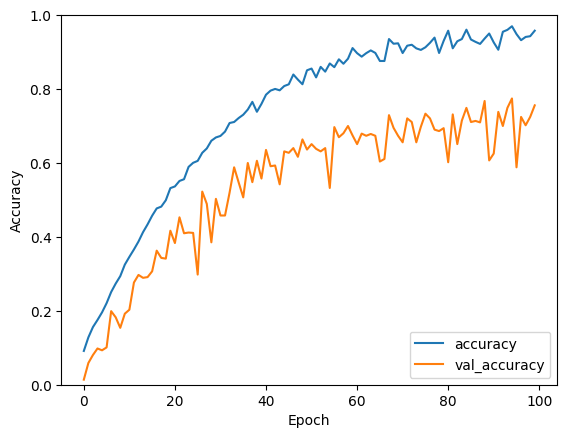

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(model, epochs=100, load_from_file=True, net_name="lrg_cnn_fine", summary=False,show_train_graph=True, data_aug=True, verbose=True)

## Train second with learning rate 0.0001

Epoch 1/50


/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


193/193 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9788 - loss: 0.4014 - val_accuracy: 0.8284 - val_loss: 0.9788
Epoch 2/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9939 - loss: 0.2602 - val_accuracy: 0.8255 - val_loss: 0.8988
Epoch 3/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9956 - loss: 0.2180 - val_accuracy: 0.8333 - val_loss: 0.8546
Epoch 4/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9958 - loss: 0.1983 - val_accuracy: 0.8353 - val_loss: 0.8085
Epoch 5/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9937 - loss: 0.2103 - val_accuracy: 0.8324 - val_loss: 0.8251
Epoch 6/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9967 - loss: 0.1827 - val_accuracy: 0.8353 - val_loss: 0.8121
Epoch 7/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9979 - loss: 0.1823 - val_accuracy: 0.8284 - val_loss: 0.8279
Epoch 8/50
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9975 - loss: 0.1767 - val_accuracy: 0.83

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train accuracy (tf): 1.00
Test accuracy  (tf): 0.83
Train balanced accuracy (tf): 1.00
Test balanced accuracy  (tf): 0.83


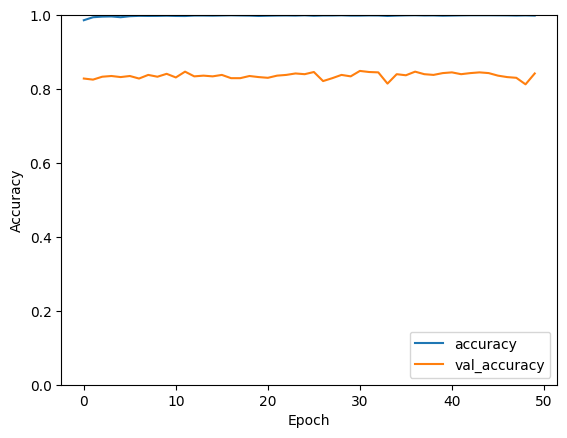

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(model, epochs=50, load_from_file=False, net_name="lrg_cnn_fine", summary=False,show_train_graph=True, data_aug=True, verbose=True)

## Train third with learning rate 0.00001

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train accuracy (tf): 1.00
Test accuracy  (tf): 0.83
Train balanced accuracy (tf): 1.00
Test balanced accuracy  (tf): 0.83


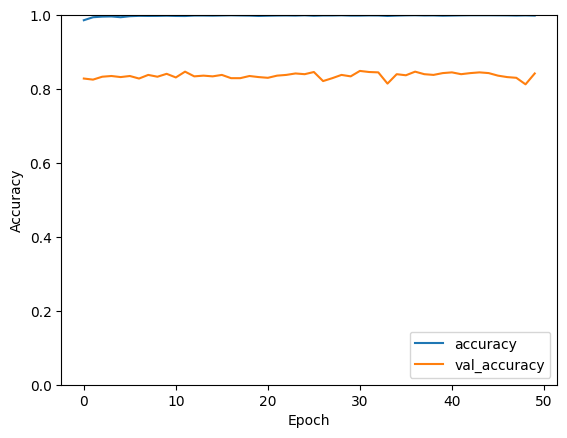

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
eval_net(model, epochs=100, load_from_file=True, net_name="lrg_cnn_fine", summary=False,show_train_graph=True, data_aug=True, verbose=True)

In [2]:
model = tf.keras.models.load_model('./saved/lrg_cnn_fine_cnn_net.h5')

2024-04-15 19:29:13.829316: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 19:29:13.848238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 19:29:13.848336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                     precision    recall  f1-score   support

            Orchids       0.96      0.87      0.91        30
Bell-shaped Flowers       1.00      0.20      0.33        10
             Lilies       0.80      0.66      0.73        50
    Tubular Flowers       0.77      0.90      0.83        40
  Composite Flowers       0.94      0.97      0.96        70
  Iris-like Flowers       0.64      0.90      0.75        40
   Dahlia Varieties       0.95      1.00      0.98        20
            Poppies       0.94      0.85      0.89        20
      Water Flowers       1.00      1.00      1.00        20
         Carnations       0.94      0.75      0.83        20

           accuracy                           0.85       320
          macro avg       0.90      0.81      0.82       320
       weighted avg       0.87      0.85      0.85       320



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[26  0  0  2  0  1  0  0  0  1]
 [ 0  2  2  4  0  2  0  0  0  0]
 [ 0  0 33  3  1 11  1  1  0  0]
 [ 0  0  0 36  0  4  0  0  0  0]
 [ 0  0  0  1 68  1  0  0  0  0]
 [ 0  0  4  0  0 36  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  1  0  2  0  0 17  0  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 1  0  1  1  1  1  0  0  0 15]]
